In [1]:
# ARIMA MODEL
# Fit an ARIMA model.

# There are three hyperparameters we need to get values for when fitting an ARIMA model.
# Determine a value of  using the Augmented Dickey-Fuller test.

# Then, determine values of  and  through GridSearching.

# An  model is specified by:
# -how many differences  we need to calculate in order to achieve stationarity.
# -how many lags  we regress  on.
# -how many errors  we regress  on.


# Depending on our values of , , and , we might refer to these models by slightly different names.
# If  and , an AR(p) model is specified by how many lags  we regress  on.
# If  and , an MA(q) model is specified by how many errors  we regress  on.
# If , an ARMA(p, q) model is specified by how many lags  and how many errors  we regress  on.

In [2]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.pipeline import Pipeline
import pymssql
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import plotly.express as px

In [3]:

database = "arctic_analysts_capstone"
user = "arctic_analysts"
password  = "ThisPassw0rd!"
server = "gen10-data-fundamentals-22-02-sql-server.database.windows.net"

def sql_query(query):
    conn = pymssql.connect(server, user, password, database)
    cursor = conn.cursor()
    queried_data = pd.read_sql(query, conn)
    return queried_data

In [4]:
def run_queries():
    tables = ["year", "month", "county", "median_income", "main_table"]

    query = f"SELECT * FROM {tables[0]}"
    year_df = sql_query(query)

    query = f"SELECT * FROM {tables[1]}"
    month_df = sql_query(query)

    query = f"SELECT * FROM {tables[2]}"
    county_df = sql_query(query)

    query = f"SELECT * FROM {tables[3]}"
    median_income_df = sql_query(query)

    query = f"SELECT * FROM {tables[4]}"
    main_table = sql_query(query)

    all_df = [year_df, month_df, county_df, median_income_df, main_table]
    return all_df

In [5]:
def join_tables(all_df):
    year_df = all_df[0]
    month_df = all_df[1]
    county_df = all_df[2]
    median_income_df = all_df[3]
    main_table = all_df[4]

    master_table = pd.merge(
        main_table, year_df, left_on="YearID", right_on="YearID", how="outer"
    )
    print(master_table.shape[0])
    # Now has 5607 rows

    master_table = pd.merge(
        master_table, month_df, left_on="MonthID", right_on="MonthID", how="outer"
    )
    # Now has 5607 rows
    print(master_table.shape[0])

    master_table = pd.merge(
        master_table, county_df, left_on="FIPS", right_on="FIPS", how="outer"
    )
    # Now has 5607 rows
    print(master_table.shape[0])

    master_table = pd.merge(
        master_table,
        median_income_df,
        left_on=["FIPS", "YearID"],
        right_on=["FIPS", "YearID"],
        how="outer",
    )
    # Now has 20727 rows
    print(master_table.shape[0])

    master_table.loc[(master_table.MedianIncome < 0), "MedianIncome"] = None
    return master_table

In [6]:
all_df = run_queries()
master_table = join_tables(all_df)

5607
5607
5607
20727


In [7]:
df = master_table.copy()

In [8]:
df

,FIPS,YearID,MonthID,NewUnits,NewBuildings,MedianHousePrice,AverageRate,AveragePoints,Year,Month,County,AgeGroup,MedianIncome
0,34001,1,1,66,66,136880.0,8.21,1.0,2000,Jan,Atlantic County,NaN,NaN
1,34001,1,2,110,110,137379.0,8.33,1.0,2000,Feb,Atlantic County,NaN,NaN
2,34001,1,3,98,87,137794.0,8.24,1.0,2000,Mar,Atlantic County,NaN,NaN
3,34001,1,4,90,90,138680.0,8.15,1.0,2000,Apr,Atlantic County,NaN,NaN
4,34001,1,5,121,121,139644.0,8.52,1.0,2000,May,Atlantic County,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20722,34041,22,11,26,14,334266.0,3.07,0.7,2021,Nov,Warren County,NaN,NaN
20723,34041,22,12,19,18,336388.0,3.10,0.6,2021,Dec,Warren County,NaN,NaN
20724,34041,23,1,13,12,338845.0,3.45,0.7,2022,Jan,Warren County,NaN,NaN
20725,34041,23,2,29,18,340046.0,3.76,0.8,2022,Feb,Warren County,NaN,NaN


In [9]:
# filtering down to Atlantic County
atlantic_df = df[df['County']=='Atlantic County']

# filtering down to the year and median house price
# atlantic_df = atlantic_df[['Year','Month','MedianHousePrice']]

# FINDING NULLS
atlantic_df[atlantic_df.isna().any(axis=1)]

# sort by year and monthID
atlantic_df.sort_values(by = ['Year', 'MonthID'], ascending = [True, True], inplace = True)


def convert_to_date(year, month):
    date = dt.datetime.strptime(f"{year}-{month}", "%Y-%b")#.date()
    # date = dt.datetime.strftime(date, "%Y-%m")
    return date


# Create a date to pass into the index for the model
atlantic_df['date'] = atlantic_df.apply(lambda row: convert_to_date(row.Year, row.Month), axis = 1)

# Get only the relevant columns
atlantic_df = atlantic_df[['MedianHousePrice', 'date']]

# Set the index as the date for the squeeze to series
atlantic_df.set_index('date', inplace = True)

series = atlantic_df.squeeze()

# Set the index as a period array
series.index = series.index.to_period('M')

atlantic_df


e:\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\hluong\AppData\Local\Temp\ipykernel_6568\4260652856.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  atlantic_df['date'] = atlantic_df.apply(lambda row: convert_to_date(row.Year, row.Month), axis = 1)


,MedianHousePrice
date,
2000-01-01,136880.0
2000-02-01,137379.0
2000-03-01,137794.0
2000-04-01,138680.0
2000-05-01,139644.0
...,...
2021-11-01,291523.0
2021-12-01,294593.0
2022-01-01,298233.0


In [10]:
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest

adf_test=ADFTest(alpha=0.05)
adf_test.should_diff(atlantic_df)

(0.9633578920635507, True)

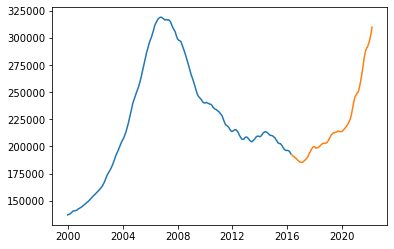

In [11]:
train=atlantic_df[:740]
test=atlantic_df[-247:]
plt.plot(train)
plt.plot(test)

In [12]:
model=auto_arima(train,start_p=0,d=2,start_q=0,
          max_p=5,max_d=5,max_q=5, start_P=0,
          D=1, start_Q=0, max_P=5,max_D=5,
          max_Q=5, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=12964.972, Time=0.04 sec
 ARIMA(1,2,0)(1,1,0)[12]             : AIC=12928.327, Time=0.58 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=12915.949, Time=0.39 sec
 ARIMA(0,2,1)(0,1,0)[12]             : AIC=12941.699, Time=0.29 sec
 ARIMA(0,2,1)(1,1,1)[12]             : AIC=inf, Time=0.81 sec
 ARIMA(0,2,1)(0,1,2)[12]             : AIC=12862.613, Time=1.35 sec
 ARIMA(0,2,1)(1,1,2)[12]             : AIC=12834.182, Time=2.50 sec
 ARIMA(0,2,1)(2,1,2)[12]             : AIC=inf, Time=3.50 sec
 ARIMA(0,2,1)(1,1,3)[12]             : AIC=12832.278, Time=4.76 sec
 ARIMA(0,2,1)(0,1,3)[12]             : AIC=12838.657, Time=1.94 sec
 ARIMA(0,2,1)(2,1,3)[12]             : AIC=12824.108, Time=9.09 sec
 ARIMA(0,2,1)(3,1,3)[12]             : AIC=12835.995, Time=8.66 sec
 ARIMA(0,2,1)(2,1,4)[12]             : AIC=12810.788, Time=9.03 sec
 ARIMA(0,2,1)(1,1,4)[12]             : AIC=12813.522, Time=7.52 sec
 ARIMA(0,2,1)(3,1

In [13]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                           SARIMAX Results                                           
=====================================================================================================
Dep. Variable:                                             y   No. Observations:                  740
Model:             SARIMAX(3, 2, 2)x(2, 1, [1, 2, 3, 4], 12)   Log Likelihood               -6284.581
Date:                                       Sun, 22 May 2022   AIC                          12593.162
Time:                                               13:29:25   BIC                          12648.212
Sample:                                                    0   HQIC                         12614.406
                                                       - 740                                         
Covariance Type:                                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4708      0.021     22.880      0.000       0.430       0.511
ar.L2         -0.7972      0.012    -64.508      0.000      -0.821      -0.773
ar.L3         -0.1523      0.009    -17.135      0.000      -0.170      -0.135
ma.L1         -0.6838      0.025    -27.015      0.000      -0.733      -0.634
ma.L2          0.7917      0.018     44.944      0.000       0.757       0.826
ar.S.L12       0.3310      0.110      3.012      0.003       0.116       0.546
ar.S.L24      -0.5948      0.069     -8.597      0.000      -0.730      -0.459
ma.S.L12      -0.4821      0.111     -4.349      0.000      -0.699      -0.265
ma.S.L24       0.4678      0.078      5.997      0.000       0.315       0.621
ma.S.L36      -0.1386      0.023     -5.956      0.000      -0.184      -0.093
ma.S.L48      -0.0742      0.019     -3.945      0.000      -0.111      -0.037
sigma2      2.231e+06   7.36e-09   3.03e+14      0.000    2.23e+06    2.23e+06
===================================================================================
Ljung-Box (L1) (Q):                  62.02   Jarque-Bera (JB):               506.60
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.15   Skew:                             0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.31e+30. Standard errors may be unstable.
"""

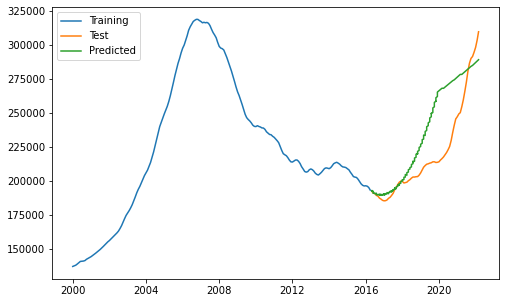

In [14]:
prediction = pd.DataFrame(model.predict(n_periods = 247),index=test.index)
prediction.columns = ['predicted']
plt.figure(figsize=(8,5))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(prediction,label="Predicted")
plt.legend(loc = 'upper left')
plt.savefig('SecondPrection.jpg')
plt.show()

In [16]:
from sklearn.metrics import r2_score
test['predicted'] = prediction
r2_score(test['MedianHousePrice'],test['predicted'])

C:\Users\hluong\AppData\Local\Temp\ipykernel_6568\3149991072.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted'] = prediction


0.10023328629827633

In [19]:
test

,MedianHousePrice,predicted
date,,
2016-05-01,192194.0,192742.629798
2016-05-01,192194.0,192728.165774
2016-05-01,192194.0,192259.052443
2016-05-01,192194.0,192414.452816
2016-05-01,192194.0,192422.384142
...,...,...
2021-11-01,291523.0,284944.063227
2021-12-01,294593.0,286010.161716
2022-01-01,298233.0,287098.192933
